# 概要
- 地球温暖化の予測
- データを用いて2017年の気温を予測

## データ
- x:時間[年]
- y:気温の相対値[度c]

## 事前知識
- 気温がある変化幅で推移している

# 状態空間モデルとは

## 前提知識
- 時系列データは完全なランダムにしたがっていない
- 何かしらの法則にしたがって変化している
- 次の状態= 今の状態 + 法則性による変化

## 仮説
- 気温はある法則で変化する
- 測定した気温は正規分布している

## 統計モデル

### 数式
- μ[n] = μ[n-1] + ε[n]
- ε[n] = Normal(0, σ_{μ})
- y[n] = Normal(μ[n] , σ)

### 変数説明
- ε:法則性のデータ
- μ:測定したい気温(状態変数)
- y:μの真の状態は測定方法によってぶれる=>μの値の周辺をうろつく

# プレゼン資料

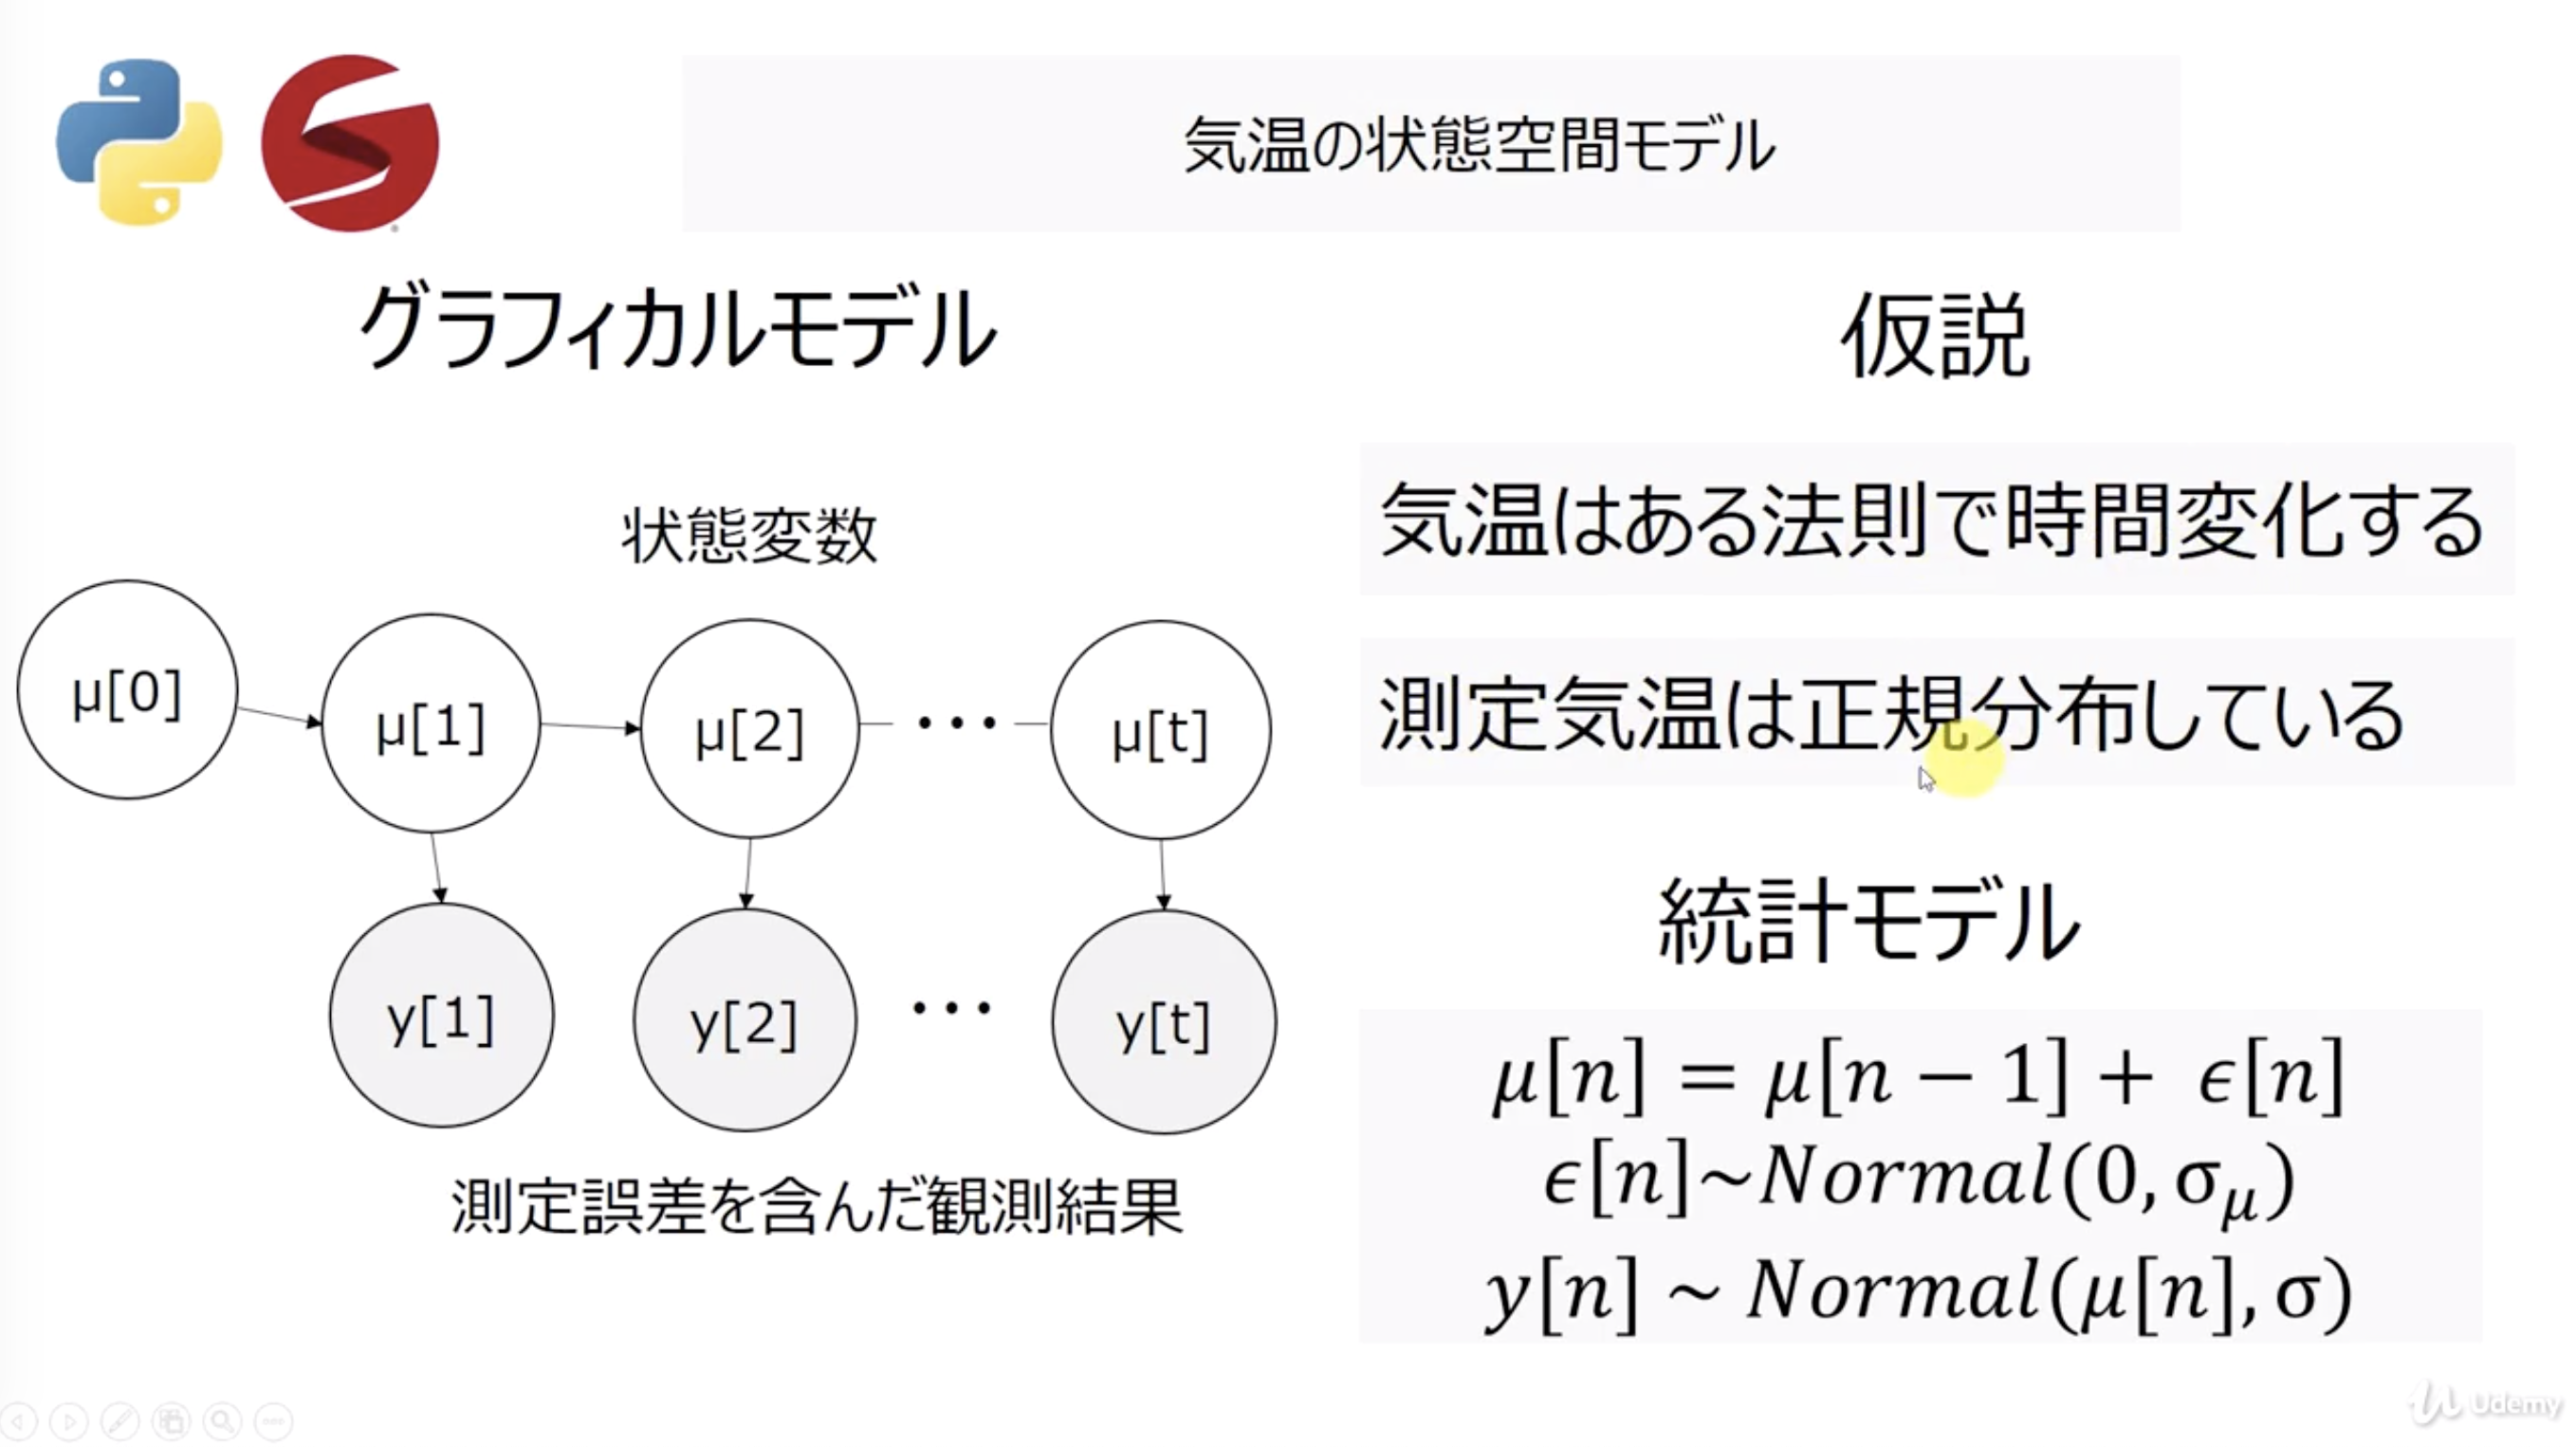

In [1]:
from IPython.display import Image, display_png
 
display_png(Image("./状態空間モデル.png"))

# 必要なライブラリのインストール

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.style.use("ggplot")
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

import pystan

# データの確認

In [3]:
df = pd.read_excel("../data/temperature_series.xlsx")

In [4]:
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


In [5]:
len(df)

121

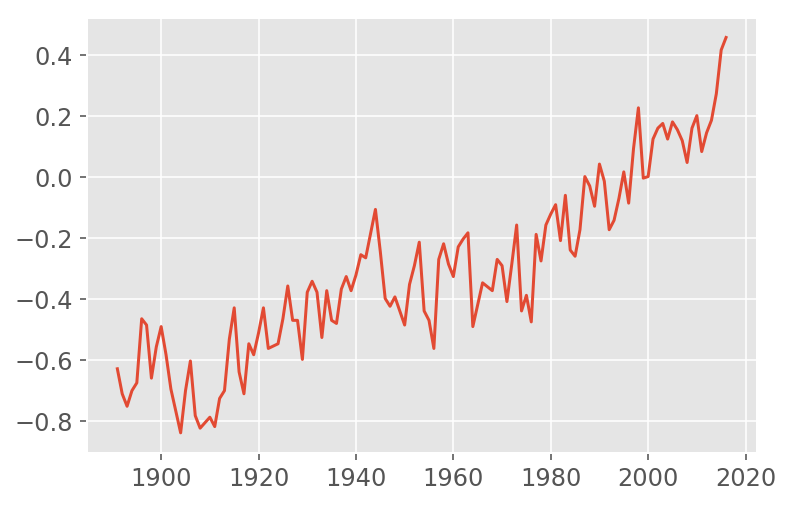

In [6]:
plt.plot(df.x, df.y)

# モデルの定義

In [18]:
df.shape[0]

121

In [7]:
stan_data = {"T":df.shape[0], "T_new":1, "Y":df.y }

In [8]:
stan_model ="""  

//モデルに与えるデータ
data {
    //時系列データの個数(持っているデータの数)
    int  T;
    
    //何個予測するか
    int T_new;
    
    //予測したデータの格納先
    real Y[T];
}

//推定するパラメータ
parameters {
    //mu = μ[T] 真の状態の格納する配列
    real mu[T];
    
    //変化具合のパラメータ
    real<lower=0> s_mu;
    
    //測定誤差(真の気温からの誤差)
    real<lower=0> s_Y;
}

//統計モデル
model {
    for (t in 2:T){
        //状態(気温)
        //normal(観測したデータ, 知りたい変数):正規分布
        mu[t] ~ normal(mu[t-1] , s_mu);
    }
    for (t in 1:T){
        //観測値
        Y[t] ~ normal(mu[t], s_Y);
    }
}

//予測した情報
generated quantities{

//データの定義
    //次の年の状態
    real mu_new;
    
    //全ての時間の状態
    real Y_new[T+T_new];

//計算    
    for (t in 1:T){
        //2016までのデータ
        Y_new[t] = normal_rng(mu[t], s_Y);
    }
    //2017までのデータ
    mu_new = normal_rng(mu[T], s_mu);
    
    //
    Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}
""" 

In [9]:
 sm = pystan.StanModel(model_code= stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf837068e47c3b4404c29f72c23f6c7d NOW.


In [16]:
fit = sm.sampling(data=stan_data,iter=3000, chains=3, warmup=1500, seed=123)

In [19]:
print(fit)

Inference for Stan model: anon_model_bf837068e47c3b4404c29f72c23f6c7d.
3 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       -0.66  8.6e-4   0.05  -0.77   -0.7  -0.66  -0.63  -0.56   3752    1.0
mu[2]       -0.69  8.6e-4   0.05  -0.78  -0.72  -0.69  -0.66   -0.6   3008    1.0
mu[3]        -0.7  1.4e-3   0.05  -0.79  -0.74   -0.7  -0.67  -0.61   1170    1.0
mu[4]       -0.68  1.0e-3   0.05  -0.77  -0.71  -0.68  -0.65  -0.59   2044    1.0
mu[5]       -0.63  6.8e-4   0.04  -0.72  -0.66  -0.63   -0.6  -0.55   4270    1.0
mu[6]       -0.55  1.9e-3   0.05  -0.65  -0.59  -0.55  -0.52  -0.45    708    1.0
mu[7]       -0.55  1.5e-3   0.05  -0.64  -0.58  -0.55  -0.51  -0.45   1065    1.0
mu[8]       -0.59  8.4e-4   0.05  -0.68  -0.62  -0.59  -0.56   -0.5   3068    1.0
mu[9]       -0.57  7.6e-4   0.04  -0.66   -0.6  -0.57  -0.54  -0.48   352

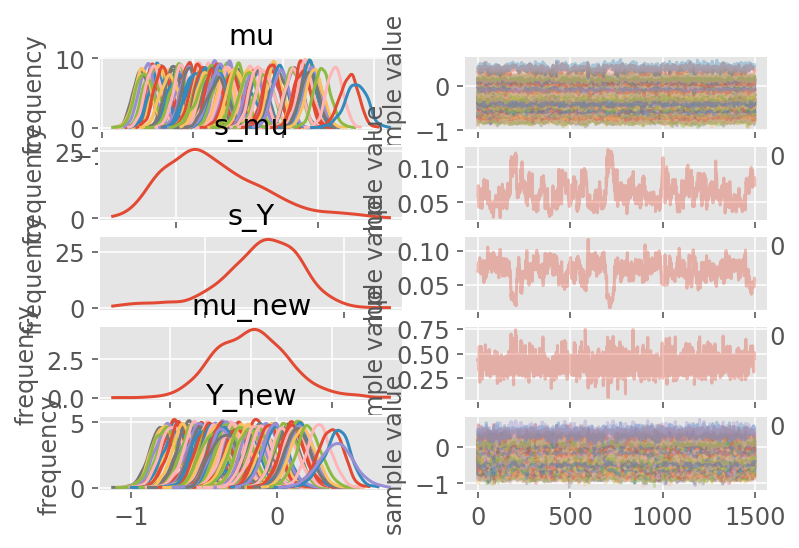

In [12]:
fig = fit.plot()

In [13]:
Y_new_arr = fit.extract("Y_new")["Y_new"]

# 予測と信頼区間

In [14]:
from scipy.stats import mstats
low_y50 , hight_y_50 = mstats.mquantiles(Y_new_arr, [0.25, 0.75], axis=0)
low_y95 , hight_y_95 =mstats.mquantiles(Y_new_arr, [0.025, 0.975], axis=0)

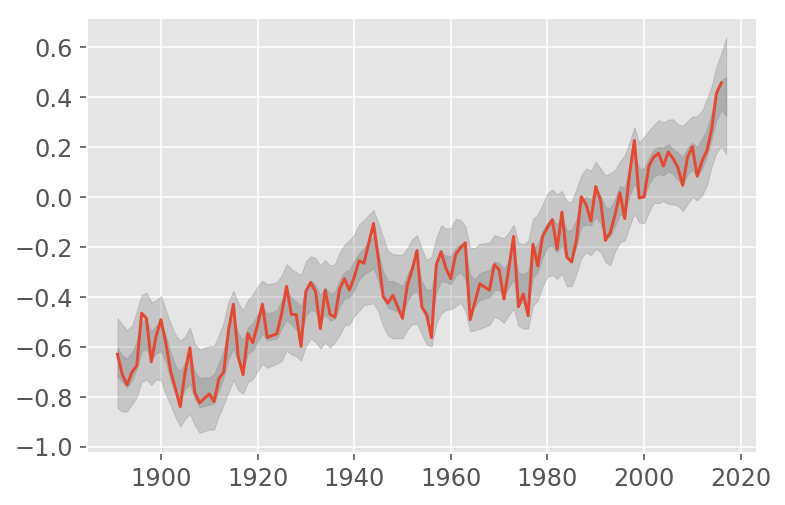

In [15]:
plt.plot(df.x, df.y)
x = df.x.values
x = np.append(x, 2017)
plt.fill_between(x, low_y50, hight_y_50,alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, hight_y_95,alpha=0.3, color="gray")